# Проверка гипотез по увеличению выручки в интернет-магазине. Приоритезация гипотез. Оценка результата А/В теста

**Задача:** Был подготовлен список гипотез для увеличения выручки крупного интернет-магазина. Используя данные
интернет-магазина необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать полученные результаты.

<a id='content'></a>
## Оглавление 
[Предварительный анализ данных](#1)

[Приоритизация гипотез](#2)
 - [Фреймворк ICE для приоритизации гипотез](#2-1)
 - [Фреймворк RICE для приоритизации гипотез](#2-2)
 - [Сводная таблица результатов](#2-3)

[Анализ A/B-теста](#3)
 - [График кумулятивной выручки по группам](#3-1)
 - [График кумулятивного среднего чека по группам](#3-2)
 - [График относительного изменения кумулятивного среднего чека группы B к группе A](#3-3)
 - [График кумулятивной конверсии по группам](#3-4)
 - [График относительного изменения кумулятивной конверсии группы B к группе A](#3-5) 
 - [График распределения количества заказов по пользователям](#3-6) 
 - [95-й и 99-й перцентили количества заказов на пользователя](#3-7)
 - [График распределения стоимостей заказов](#3-8)
 - [95-й и 99-й перцентили стоимости заказов](#3-9)
 - [Проверка статистической значимости различий в конверсии между группами по неотфильтрованным данным](#3-11)
 - [Проверка статистической значимости различий в среднем чеке заказа между группами по неотфильтрованным данным](#3-12)
 - [Проверка статистической значимости различий в конверсии между группами по отфильтрованным данным](#3-13) 
 - [Проверка статистической значимости различий в среднем чеке заказа между группами по отфильтрованным данным](#3-14)
 
[Вывод](#4)

<a id = '1'></a>
## Предварительный анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  

In [2]:
# импорт данных
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Проверка датасета Hypothesis

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.duplicated().sum()

0

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


В датасете нет дубликатов и пропусков. Названия столбцов приведены к одному регистру

### Проверка датасета Orders

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.duplicated().sum()

0

In [9]:
orders = orders.rename(columns={'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'})

In [10]:
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В датасете нет дубликатов и пропусков. Названия столбцов приведены к стилю snake. Дата приведена к формату datetime64

### Проверка датасета Visitors

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
visitors.duplicated().sum()

0

In [14]:
visitors['date'] = pd.to_datetime(visitors['date'])

visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


В датасете нет дубликатов и пропусков. Дата приведена к формату datetime64

Проверка наличия пользователей, попавших одновременно в обе группы

In [15]:
same_visitors = (set(orders[orders['group'] == 'A']['visitor_id']
                    .unique()).intersection(orders[orders['group'] == 'B']['visitor_id'].unique()))
len(same_visitors)

58

In [16]:
# удаление повторяющхся пользователей из датасета orders
orders = orders.query('visitor_id not in @same_visitors')

58 пользователей попали в обе группы одновременно и были удалены из датасета

[К оглавлению](#content)

<a id = '2'></a>
## Приоритизация гипотез

<a id = '2-1'></a>
### Фреймворк ICE для приоритизации гипотез

In [17]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])
hypothesis['ICE'] = hypothesis['ICE'].round(2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективые гипотезы по ICE: 8, 0, 7, 6 и 2

[К оглавлению](#content)

<a id = '2-2'></a>
### Фреймворк RICE для приоритизации гипотез

In [18]:
hypothesis['RICE'] = hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']/ hypothesis['efforts']

display(hypothesis[['hypothesis', 'reach', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,reach,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,3.0


[К оглавлению](#content)

<a id = '2-3'></a>
### Сводная таблица результатов

In [19]:
cm = sns.light_palette("green", as_cmap=True)
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False).style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


Наиболее перспективые гипотезы по RICE: <br>
7я - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",<br>
2я - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",<br>
0я - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", <br>
6я - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",<br>
и 8я - "Запустить акцию, дающую скидку на товар в день рождения"<br>

Песпективные гипотезы по RICE совпадают с перспективными гипотезами по ICE, но изменяется их порядок из-за влияния параметра reach

[К оглавлению](#content)

<a id = '3'></a>
## Анализ A/B-теста

<a id = '3-1'></a>
### График кумулятивной выручки по группам

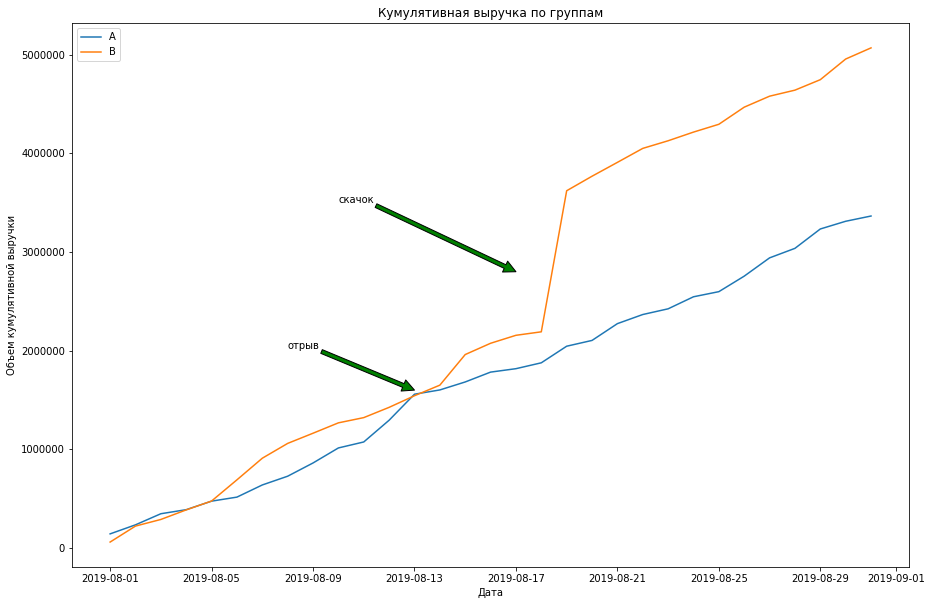

In [20]:
# подготовка данных
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Размер графика
plt.figure(figsize=(15, 10)) 

# График выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# График выручки группы B

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-13', 1600000), xytext=('2019-08-08', 2020000),
            arrowprops=dict(facecolor='g')) 


plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Объем кумулятивной выручки')
plt.legend() 
plt.show()

В середине теста группа B скачкообразно вырвалась вперед и продолжала лидировать весь отстаток теста. Возможно, это произошло в результате сильного влияния выброса

[К оглавлению](#content)

<a id = '3-2'></a>
### График кумулятивного среднего чека по группам

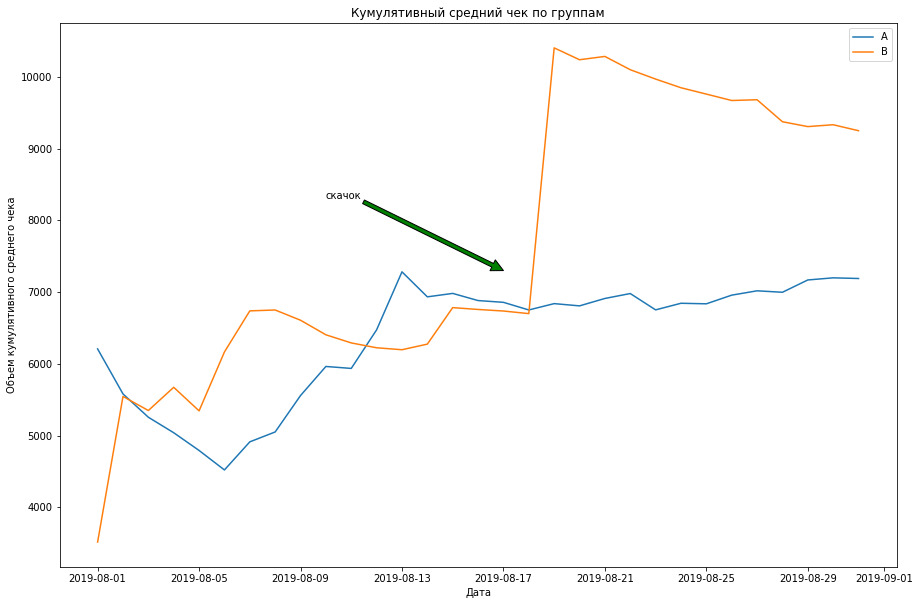

In [33]:
plt.figure(figsize=(15, 10)) 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 7300), xytext=('2019-08-10', 8300),
            arrowprops=dict(facecolor='g'))

plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Объем кумулятивного среднего чека')
plt.legend()
plt.show()

Кумулятивное значение среднего чека по грруппам имеет сильные колебания. В середине теста в группе В наблюдается сильный скачок, на конец теста средний чек группы B сильно выше чем в группе А. Требуется дополнительный анализ выбросов

[К оглавлению](#content)

<a id = '3-3'></a>
### График относительного изменения кумулятивного среднего чека группы B к группе A

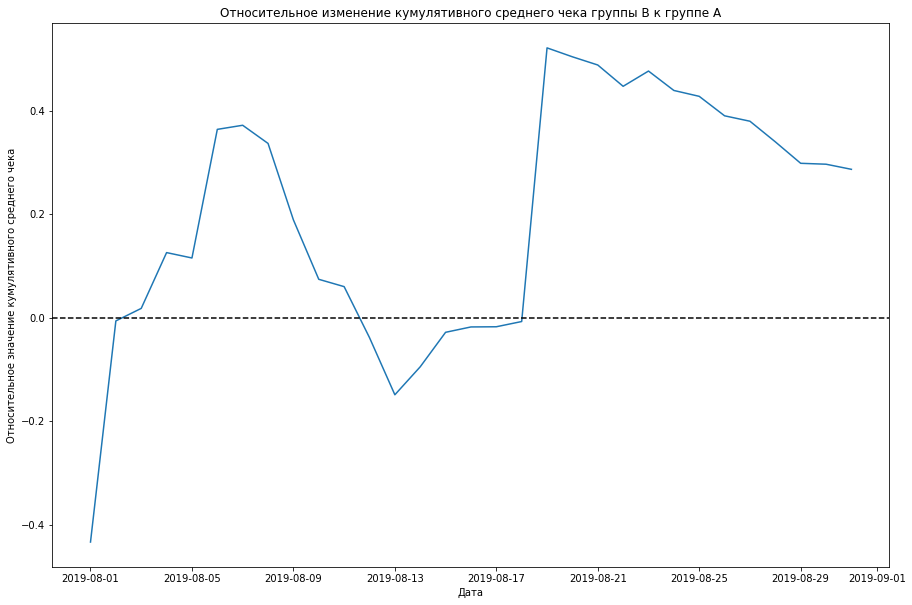

In [35]:
# подготовка данных
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# построение графика
plt.figure(figsize=(15, 10)) 
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное значение кумулятивного среднего чека')
plt.show()

Результаты теста значительно и резко менялись в несколько дат. Необходимо проверить датасет на наличие аномальных заказов 

[К оглавлению](#content)

<a id = '3-4'></a>
### График кумулятивной конверсии по группам

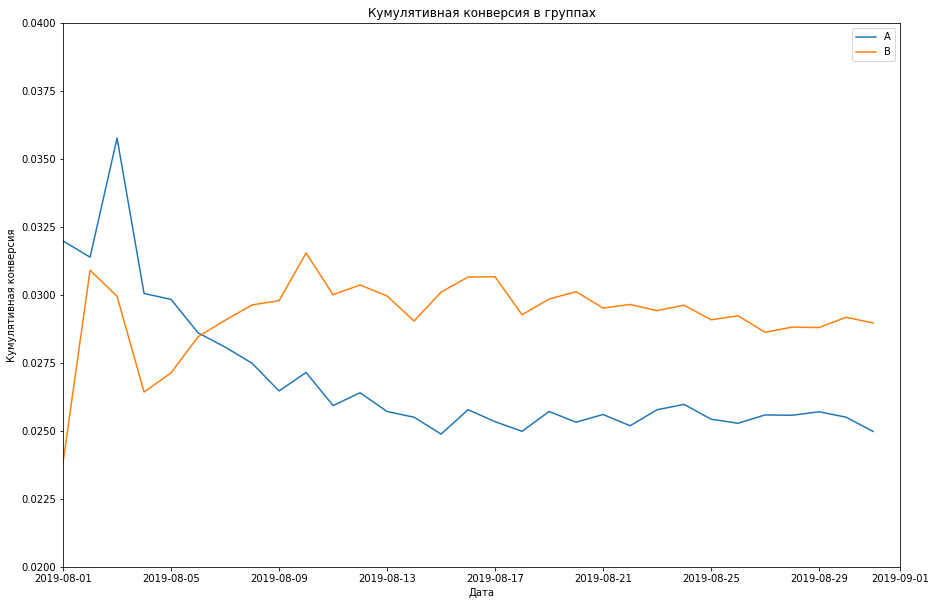

In [23]:
# расчет кумулятивной конверсии
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# построение графика
plt.figure(figsize=(15, 10)) 
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.04]) 

plt.title('Кумулятивная конверсия в группах')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.show()

На момент окончания тестирования конверсия группы B выше конверсии группы А. 

[К оглавлению](#content)

<a id = '3-5'></a>
### График относительного изменения кумулятивной конверсии группы B к группе A

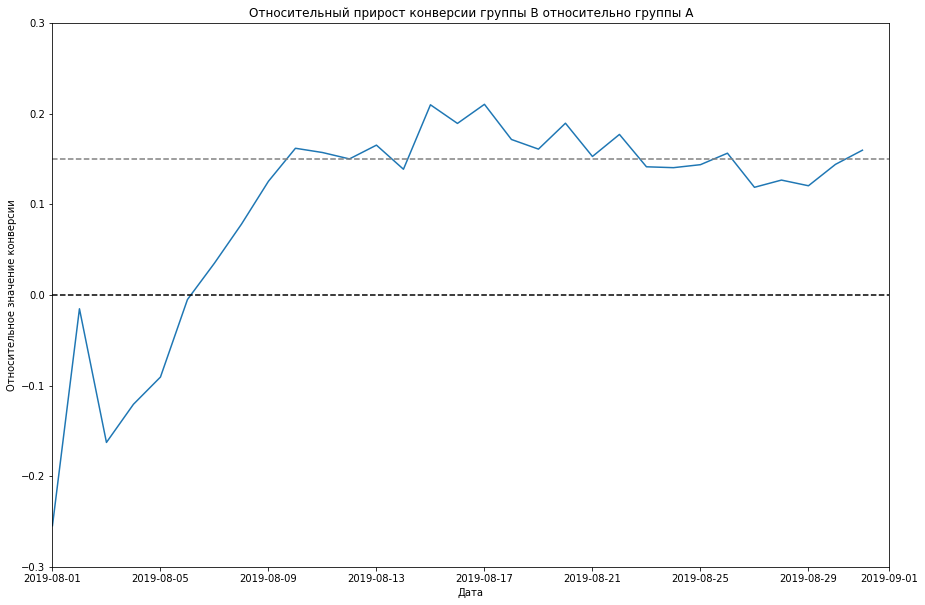

In [24]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.3])

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Относительное значение конверсии')
plt.show()

Почти с самого начала теста, группа В лидирует по конверсии. На момент окончания теста, прирост конверсии в группе В около 15% относительно группы А

[К оглавлению](#content)

<a id = '3-6'></a>
### График распределения количества заказов по пользователям

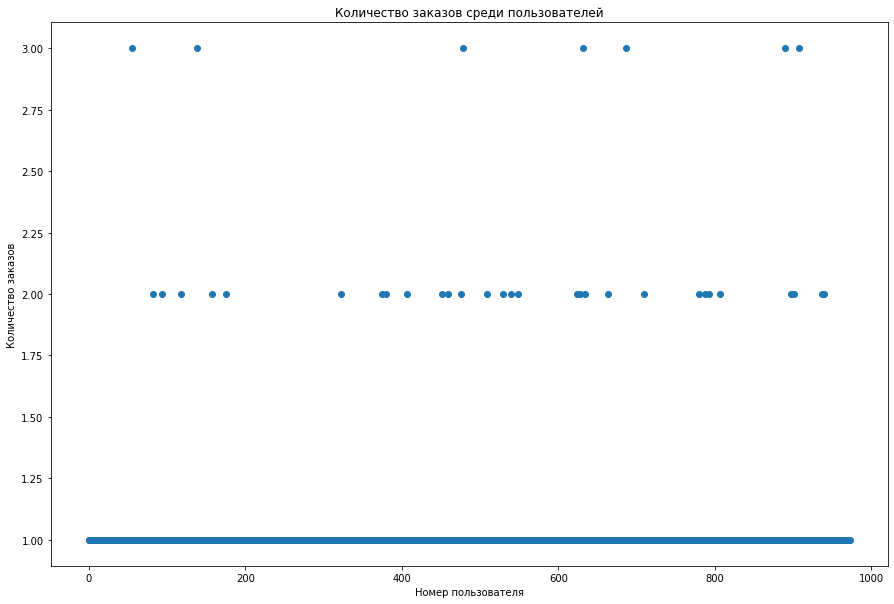

In [25]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

# построение графика
plt.figure(figsize=(15, 10))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 

plt.title('Количество заказов среди пользователей')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.show()

Пользователей, сделавших больше одного заказа, мало. Это могут быть аномалии

[К оглавлению](#content)

<a id = '3-7'></a>
### 95-й и 99-й перцентили количества заказов на пользователя

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% совершали больше 1х заказа и не более 1% пользователей больше 2

[К оглавлению](#content)

<a id = '3-8'></a>
### График распределения стоимостей заказов

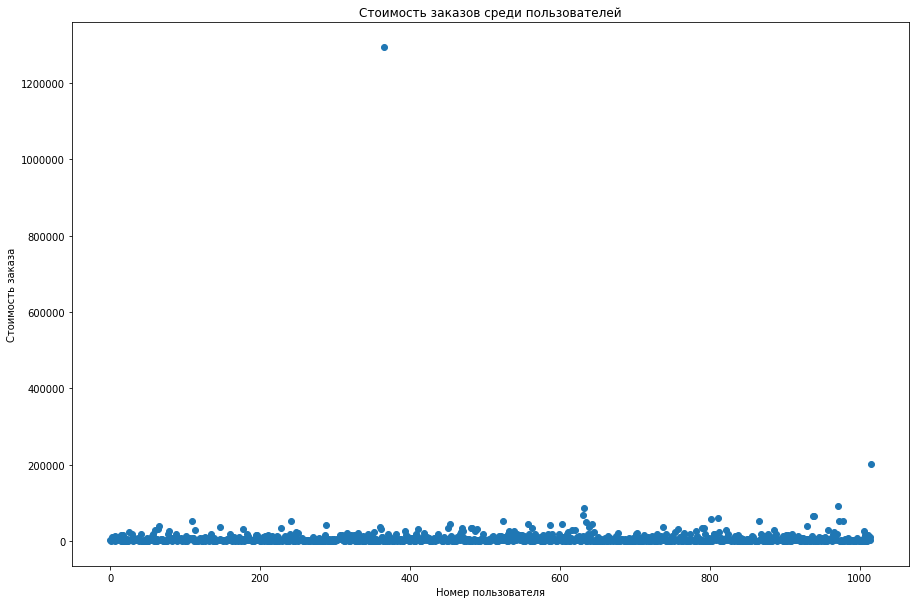

In [27]:
plt.figure(figsize=(15, 10))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('Стоимость заказов среди пользователей')
plt.xlabel('Номер пользователя')
plt.ylabel('Стоимость заказа')
plt.show()

Есть выброс, который мог сильно исказить результат

[К оглавлению](#content)

<a id = '3-9'></a>
### 95-й и 99-й перцентили стоимости заказов

In [28]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более чем у 5% заказов чек дороже 26785. И не более чем у 1% пользователей чек дороже 58904

[К оглавлению](#content)

<a id = '3-11'></a>
### Проверка статистической значимости различий в конверсии между группами по неотфильтрованным данным

Проверка, существует ли статистически значимая разница между конверсиями в группах А и В <br>
1. <u>Нулевая гипотеза:</u> не существует статистически значимой разницы между конверсиями в группах А и В <br>
2. <u>Альтернативная гипотеза:</u> существует статистически значимая разница между конверсиями в группах А и В <br>


In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: '"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print('Относительный прирост конверсии: '"{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value: 0.01102
Относительный прирост конверсии: 0.160


p-value меньше 0.05, поэтому нулевую гипотезу отвергаем: в конверсиях между группами есть статистически значимые различия. 
<br>
Относительный прирост конверсии группы В относительно конверсии группы А равен 16.0% 

[К оглавлению](#content)

<a id = '3-12'></a>
### Проверка статистической значимости различий в среднем чеке заказа между группами по неотфильтрованным данным

Проверка, существует ли статистически значимая разница между средними чеками в группах А и В <br>
1. <u>Нулевая гипотеза:</u> не существует статистически значимой разницы между средними чеками в группах А и В <br>
2. <u>Альтернативная гипотеза:</u> существует статистически значимая разница между средними чеками в группах А и В <br>

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('transaction_id', as_index=False)
    .agg({'visitor_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('transaction_id', as_index=False)
    .agg({'visitor_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('p-value: ''{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительный прирост среднего чека: ''{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный прирост среднего чека: 0.287


p-value больше 0.05, поэтому нулевую гипотезу принимаем: в среднем чеке заказа между группам нет статистически значимых различий. Не смотря на то, что относительное различие среднего чека между группами 28,7%. <br>Возможно, столь большое различие появилось из-за аномальных заказов

[К оглавлению](#content)

<a id = '3-13'></a>
### Проверка статистической значимости различий в конверсии между группами по отфильтрованным данным

Проверка, существует ли статистически значимая разница между конверсиями в группах А и В после фильтрации данных<br><br>
1. <u>Нулевая гипотеза:</u> не существует статистически значимой разницы между конверсиями в группах А и В <br>
2. <u>Альтернативная гипотеза:</u> существует статистически значимая разница между конверсиями в группах А и В <br>

Будут отфильтрованы пользователи:<br>
 - кто сделал 2 заказа и больше<br>
 - чей средний чек больше 40000 

In [31]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00575
0.198


p-value меньше 0.05, нулевую гипотезу отвергаем: в конверсиях между группами существует статистическая разница
<br>
Относительный прирост конверсии группы В относительно конверсии группы А равен 19.8%

[К оглавлению](#content)

<a id = '3-14'></a>
### Проверка статистической значимости различий в среднем чеке заказа между группами по отфильтрованным данным

Проверка, существует ли статистически значимая разница между средними чеками в группах А и В после фильтрации данных<br>
1. <u>Нулевая гипотеза:</u> не существует статистически значимой разницы между средними чеками в группах А и В <br>
2. <u>Альтернативная гипотеза:</u> существует статистически значимая разница между средними чеками в группах А и В <br>

In [32]:
print('p-value: '
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative = 'two-sided'
        )[1]
    )
)

print('Относительный прирост среднего чека: '
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)


p-value: 0.837
Относительный прирост среднего чека: 0.076


p-value больше 0.05, поэтому нулевую гипотезу принимаем: в среднем чеке заказа между группам нет статистически значимых различий. Результат совпадает с неотфильтрованными данными<br> В отфильтрованных данных разница между чеками 7.6%, что значительно ниже, чем в неотфильтрованных данных (28,7%)



[К оглавлению](#content)

<a id = '4'></a>
## Вывод

Была проведена предобработка данных, в результате которой были удалены пользователи, которые одновременно присутствовали в обеих группах.<br>  
Наиболее перспективые гипотезы по фреймворку RICE: <br>
7я - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",<br>
2я - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",<br>
0я - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", <br>
6я - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",<br>
и 8я - "Запустить акцию, дающую скидку на товар в день рождения"<br>
Песпективные гипотезы по фреймворку RICE совпали с перспективными гипотезами по фреймворку ICE, но изменился их порядок из-за влияния параметра охвата

Кумулятивные метрики по выручке, среднему чеку и конверсии большее время тестирования лидировали в группе B. 
До фильтрации аномальных значений данных, на графиках кумулятивной выручки и кумулятивного среднего чека в группе В присутствовали резкие колебания. <br><br>
Разница между средними чеками не является статистически значимой. После фильтрации данных разница между средними чеками заметно снизилась: с 28.7% до 7.6%.<br>
До и после очистки данных разница в конверсиях между группами статистически значимая. Показатель конверсии в группе B больше показателя в группе A на 19.8% (после фильтрации данных от выбросов).<br><br>    
<b>Вывод</b>: Разница показателей конверсии между группами и до и после фильтрации данных является <u>статистически значимой</u>, график конверсии говорит о фиксации результата. Это  позволяет сделать вывод о том, что A/B тест стоит остановить и зафиксировать рост конверсии в группе В

[К оглавлению](#content)